In [15]:
import os
import struct
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import joblib
import pandas as pd
import cv2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Flatten, Reshape, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import configparser
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [16]:
# Load configuration file
config = configparser.ConfigParser()
config.read('config.ini')

binary_folder = config['PATHS']['binary_folder']
output_folder = config['PATHS']['output_folder']
input_days= int(config['FORECAST']['input_days'])
actual_next24_binary_folder = config['PATHS']['actual_next24_binary_folder']


In [17]:
def load_binary_data(binary_folder):
    """
    Loads and decodes all binary files in the specified folder into numpy arrays.
    """
    data_sequences = []
    filenames = []
    filepaths = [os.path.join(binary_folder, fname) 
                 for fname in sorted(os.listdir(binary_folder)) if fname.endswith('.bin')]
    for filepath in filepaths:
        with open(filepath, "rb") as file:
            binary_data = file.read()
        unpacked_data = struct.unpack("<1024f", binary_data)
        panel_data = np.array(unpacked_data).reshape((32, 32, 1))
        data_sequences.append(panel_data)
        filenames.append(os.path.basename(filepath))
    return np.array(data_sequences), filenames


In [18]:
def scale_data(data, scaler=None, save_path=None):
    """
    Scales data using MinMaxScaler and optionally saves the scaler.
    """
    data_flat = data.flatten().reshape(-1, 1)
    if scaler is None:
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data_flat = scaler.fit_transform(data_flat)
    else:
        scaled_data_flat = scaler.transform(data_flat)
    scaled_data = scaled_data_flat.reshape(data.shape)
    return scaled_data, scaler


Autoencoder Setup

In [19]:


class CustomAutoencoder(Model):
    def __init__(self, encoder, decoder):
        super(CustomAutoencoder, self).__init__()
        self.encoder_model = encoder
        self.decoder_model = decoder

    def call(self, inputs):
        latent = self.encoder_model(inputs)
        reconstructed = self.decoder_model(latent)
        return reconstructed

    def encoder(self):
        return self.encoder_model

    def decoder(self):
        return self.decoder_model

    def get_config(self):
        config = super(CustomAutoencoder, self).get_config()
        config.update({
            "encoder": self.encoder_model.get_config(),
            "decoder": self.decoder_model.get_config()
        })
        return config

def build_autoencoder():
    latent_dim = 64
    input_img = Input(shape=(32, 32, 1))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = Dropout(0.1)(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Dropout(0.1)(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Flatten()(x)
    latent = Dense(latent_dim, activation='tanh')(x)
    encoder = Model(inputs=input_img, outputs=latent, name="encoder_64")

    decoder_input = Input(shape=(latent_dim,))
    x = Dense(8 * 8 * 64, activation='tanh')(decoder_input)
    x = Reshape((8, 8, 64))(x)
    x = Conv2DTranspose(64, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = Conv2DTranspose(32, (3, 3), activation='relu', strides=2, padding='same')(x)
    decoded_output = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)
    decoder = Model(inputs=decoder_input, outputs=decoded_output, name="decoder")

    autoencoder = CustomAutoencoder(encoder, decoder)
    return autoencoder


In [20]:
def augment_thermal_image(thermal_image):
    probability = 0.1
    image = thermal_image.squeeze()  # Remove the singleton dimension
    if np.random.choice([0, 1], p=[1-probability, probability]): 
        image = cv2.rotate(image, cv2.ROTATE_180)
    elif np.random.choice([0, 1], p=[1-probability, probability]): 
        image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    elif np.random.choice([0, 1], p=[1-probability, probability]): 
        image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
       
    if np.random.choice([0, 1], p=[1-probability, probability]): 
        image = cv2.flip(image, 0)
    elif np.random.choice([0, 1], p=[1-probability, probability]): 
        image = cv2.flip(image, 1)
    elif np.random.choice([0, 1], p=[1-probability, probability]): 
        image = cv2.flip(image, -1)
    image = image.reshape((32, 32, 1))
    return image

def augment_dataset(X_train, num_augmentations=1):
    augmented_images = []
    for _ in range(num_augmentations):
        for img in X_train:
            aug_img = augment_thermal_image(img)
            augmented_images.append(aug_img)
    augmented_images = np.array(augmented_images)
    return augmented_images


Main autoencoder Training Loop

Model: "encoder_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │       262,208 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 281,024 (1.07 MB)

 Trainable params: 281,024 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4096)           │       266,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 16, 16, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 32, 32, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321,921 (1.23 MB)

 Trainable params: 321,921 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0095 - val_loss: 0.0042
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0037 - val_loss: 0.0010
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013 - val_loss: 7.6305e-04
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.0986e-04 - val_loss: 6.3025e-04
Epoch 5/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.5426e-04 - val_loss: 5.7586e-04
Epoch 6/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.9913e-04 - val_loss: 5.6821e-04
Epoch 7/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.7100e-04 - val_loss: 5.7755e-04
Epoch 8/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.5416e-04 - val_loss: 5.6760e-04
Epoch 9/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.3395e-04 - val_loss: 5.5757e-04
Epoch 10/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.1640e-04 - val_loss: 5.5156e-04
Epoch 11/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.0070e-04 - val_l

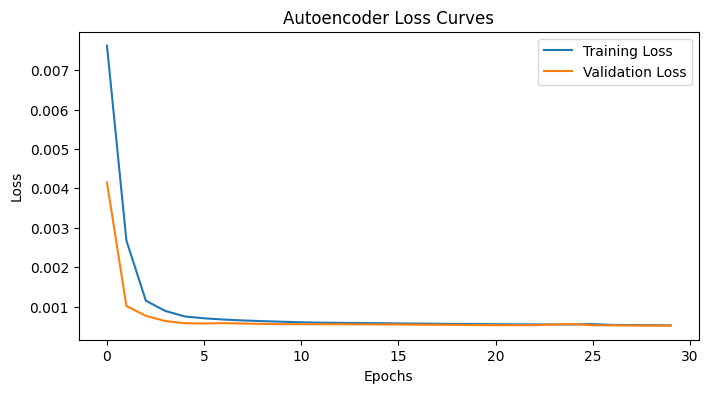

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


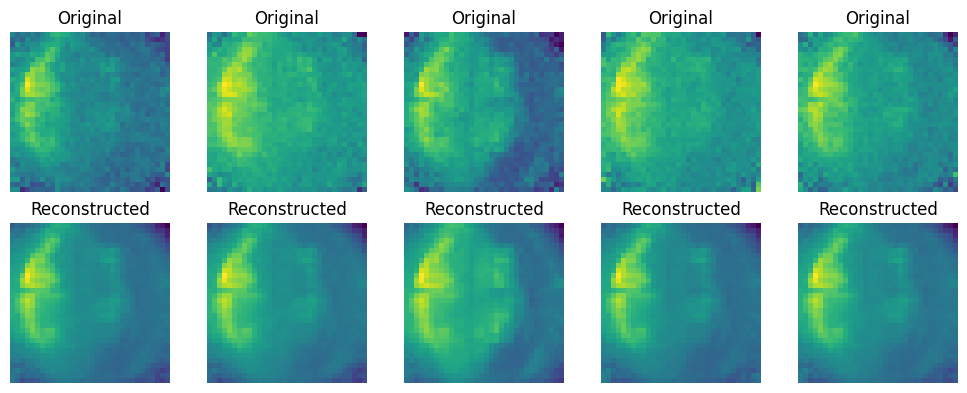

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
All outputs saved in the folder: ./output


In [21]:
def parse_datetime(filename):
    """
    Parse a filename (e.g., prefix_YYYYMMDD_HHMMSS.bin) into a datetime object.
    """
    basename = os.path.basename(filename)
    parts = basename.split('_')  
    date_str = parts[1]          
    time_str = parts[2].replace('.bin', '') 
    datetime_str = date_str + time_str       
    datetime_obj = pd.to_datetime(datetime_str, format='%Y%m%d%H%M%S')
    return datetime_obj

def plot_loss(history, folder_path, title="Loss Curves"):
    """
    Plot training and validation loss curves and save to folder.
    """
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig(os.path.join(folder_path, "loss_curves.png"))
    plt.show()

def display_reconstruction(autoencoder, data, folder_path, n=5):
    """
    Visualize original and reconstructed images and save the plot to folder.
    """
    indices = np.random.randint(0, data.shape[0], size=n)
    sample_images = data[indices]
    reconstructed = autoencoder.predict(sample_images)

    plt.figure(figsize=(10, 4))
    for i in range(n):
        # Original Image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(sample_images[i].reshape(32, 32), cmap='viridis')
        plt.title('Original')
        plt.axis('off')

        # Reconstructed Image
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].reshape(32, 32), cmap='viridis')
        plt.title('Reconstructed')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(folder_path, "reconstructed_images.png"))
    plt.show()

def main():
    np.random.seed(42)
    tf.random.set_seed(42)
    random.seed(42)

    data_sequences, filenames = load_binary_data(binary_folder)

    filtered_data = []
    filtered_filenames = []

    for i, thermal_data in enumerate(data_sequences):
        # Check if max < 90 and min > -30 (based on the unscaled values)
        if thermal_data.max() < 90 and thermal_data.min() > -30:
            filtered_data.append(thermal_data)
            filtered_filenames.append(filenames[i])
        else:
            pass

    filtered_data = np.array(filtered_data)
    filtered_filenames = np.array(filtered_filenames)

    # If all data is filtered out, you may want to handle that case:
    if len(filtered_data) == 0:
        raise ValueError("No data met the min/max temperature criteria. Exiting.")

    # Now scale only the valid data
    scaled_data, scaler = scale_data(filtered_data)

    # Save the scaler using joblib
    scaler_path = os.path.join(output_folder, 'scaler.joblib')
    joblib.dump(scaler, scaler_path)

    # Split data into training and validation sets
    X_train, X_val = train_test_split(scaled_data, test_size=0.2, random_state=42)

    # Apply data augmentation to X_train
    num_augmentations = 1  
    augmented_images = augment_dataset(X_train, num_augmentations=num_augmentations)

    # Combine original and augmented data
    X_train_augmented = np.concatenate((X_train, augmented_images), axis=0)

    # Shuffle the augmented dataset
    shuffle_indices = np.random.permutation(X_train_augmented.shape[0])
    X_train_augmented = X_train_augmented[shuffle_indices]

    # Build and train autoencoder
    autoencoder = build_autoencoder()
    autoencoder.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")
    autoencoder.encoder().summary()
    autoencoder.decoder().summary()

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = autoencoder.fit(
        X_train_augmented, X_train_augmented,
        epochs=30,
        batch_size=8,
        validation_data=(X_val, X_val),
        callbacks=[early_stopping]
    )

    model_path = os.path.join(output_folder, "convolutional_autoencoder.keras")
    autoencoder.save(model_path)

    plot_loss(history, folder_path=output_folder, title="Autoencoder Loss Curves")

    display_reconstruction(autoencoder, X_val, folder_path=output_folder)

    latent_vectors = autoencoder.encoder().predict(scaled_data)
    latent_vectors_df = pd.DataFrame(latent_vectors, index=filtered_filenames)

    datetimes = [parse_datetime(fn) for fn in latent_vectors_df.index]
    latent_vectors_df['datetime'] = datetimes
    latent_vectors_df.set_index('datetime', inplace=True)
    latent_vectors_df.index = latent_vectors_df.index.floor('h')
    latent_vectors_df.sort_index(inplace=True)
    latent_vectors_df.index.name = None
    latent_vectors_df = latent_vectors_df[~latent_vectors_df.index.duplicated(keep='first')]

    latent_vectors_path = os.path.join(output_folder, "latent_vectors.csv")
    latent_vectors_df.to_csv(latent_vectors_path)

    print(f"All outputs saved in the folder: {output_folder}")


if __name__ == "__main__":
    main()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Image 1: Reconstruction MSE = 0.003070
Image 2: Reconstruction MSE = 0.000560
Image 3: Reconstruction MSE = 0.000489
Image 4: Reconstruction MSE = 0.000576
Image 5: Reconstruction MSE = 0.001960
Overall Reconstruction MSE on test data: 0.001331070220774715
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


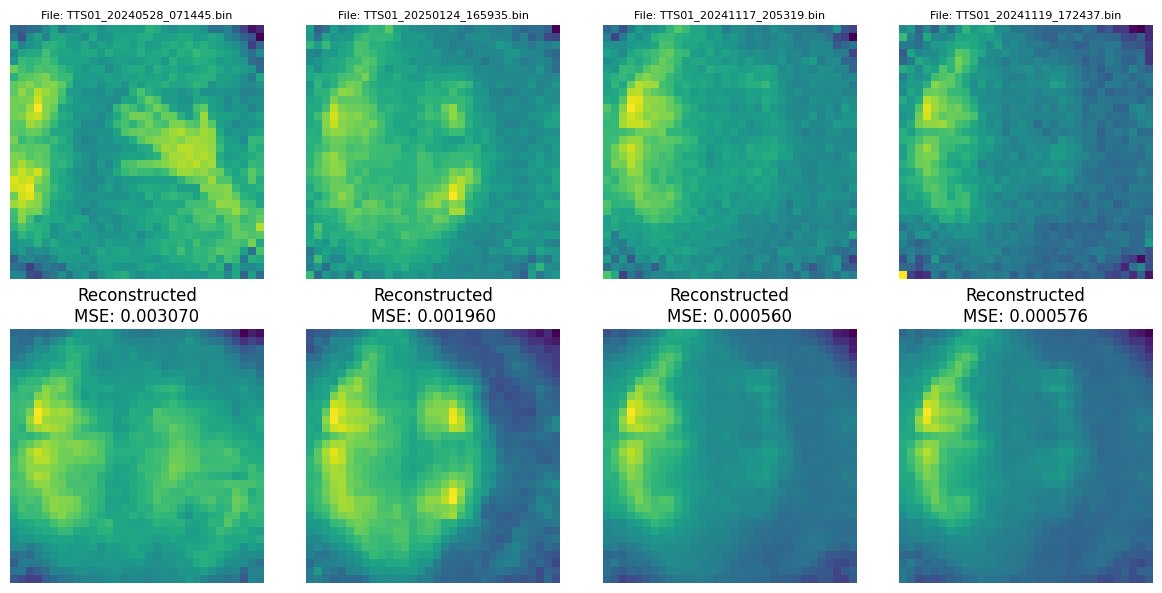

In [22]:
from autoencoder import CustomAutoencoder

def display_reconstruction(autoencoder, data, file_names, n=4):
    """
    Visualize original and reconstructed images with Reconstruction MSE and file names displayed.
    """
    indices = np.random.choice(data.shape[0], size=n, replace=False)
    sample_images = data[indices]
    sample_file_names = [file_names[i] for i in indices]
    reconstructed = autoencoder.predict(sample_images)
    mse_per_image = np.mean((sample_images - reconstructed) ** 2, axis=(1, 2, 3))

    plt.figure(figsize=(12, 6))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(sample_images[i].reshape(32, 32), cmap='viridis')
        plt.title(f'File: {sample_file_names[i]}', fontsize=8)
        plt.axis('off')

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].reshape(32, 32), cmap='viridis')
        plt.title(f'Reconstructed\nMSE: {mse_per_image[i]:.6f}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def evaluate_model(autoencoder, test_data, file_names, scaler):
    """
    Test the autoencoder on new data and evaluate reconstruction loss for each image.
    """
    scaled_test_data, _ = scale_data(test_data, scaler=scaler)
    reconstructed = autoencoder.predict(scaled_test_data)
    mse_per_image = np.mean((scaled_test_data - reconstructed) ** 2, axis=(1, 2, 3))
    for i, mse in enumerate(mse_per_image):
        print(f"Image {i + 1}: Reconstruction MSE = {mse:.6f}")
    overall_mse = np.mean(mse_per_image)
    print(f"Overall Reconstruction MSE on test data: {overall_mse}")
    display_reconstruction(autoencoder, scaled_test_data, file_names)

def test_autoencoder():
    config = configparser.ConfigParser()
    config.read('config.ini')
    test_binary_folder = config['PATHS']['test_binary_folder']
    output_folder = config['PATHS']['output_folder']
    test_data, file_names = load_binary_data(test_binary_folder)
    image_scaler_path = os.path.join(output_folder, 'scaler.joblib')
    scaler = joblib.load(image_scaler_path)
    autoencoder_path = os.path.join(output_folder, "convolutional_autoencoder.keras")
    autoencoder = load_model(
        autoencoder_path, compile=False, custom_objects={"CustomAutoencoder": CustomAutoencoder}
    )
    evaluate_model(autoencoder, test_data, file_names, scaler)

test_autoencoder()


Forecasting Functionality

In [23]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Attention, AdditiveAttention, Concatenate)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.dates as mdates
from sklearn.manifold import TSNE
import seaborn as sns
from pathlib import Path

Latent Vectors DF: (721, 64)
                            0         1         2         3         4  \
2024-10-13 00:00:00  0.059108  0.182388  0.028020  0.089369 -0.102088   
2024-10-13 01:00:00  0.086996  0.191136  0.017406  0.070733 -0.081361   
2024-10-13 02:00:00  0.057345  0.186255  0.027841  0.101014 -0.094350   
2024-10-13 03:00:00  0.035788  0.220394  0.023172  0.115392 -0.090202   
2024-10-13 04:00:00  0.076676  0.159442  0.030163  0.096628 -0.085824   

                            5         6         7         8         9  ...  \
2024-10-13 00:00:00 -0.182490 -0.175108  0.168782  0.136387  0.057194  ...   
2024-10-13 01:00:00 -0.162343 -0.157746  0.157527  0.122596  0.044356  ...   
2024-10-13 02:00:00 -0.177582 -0.184388  0.155729  0.126896  0.049089  ...   
2024-10-13 03:00:00 -0.175628 -0.184289  0.159413  0.142788  0.050857  ...   
2024-10-13 04:00:00 -0.180026 -0.164295  0.148140  0.116417  0.050350  ...   

                           54        55        56        57    

Model: "Seq2Seq_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_inputs (InputLayer)     │ (None, 168, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_lstm (LSTM)             │ (None, 96)             │        61,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dropout (Dropout)       │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_repeat_vector           │ (None, 24, 96)         │             0 │
│ (RepeatVector)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_lstm (LSTM)             │ (None, 24, 96)         │        74,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dropout2 (Dropout)      │ (None, 24, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense (TimeDistributed) │ (None, 24, 64)         │         6,208 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,144 (555.25 KB)

 Trainable params: 142,144 (555.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0138 - val_loss: 0.0102 - learning_rate: 0.0010
Epoch 2/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0084 - val_loss: 0.0093 - learning_rate: 0.0010
Epoch 3/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0080 - val_loss: 0.0091 - learning_rate: 0.0010
Epoch 4/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0078 - val_loss: 0.0086 - learning_rate: 0.0010
Epoch 5/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0075 - val_loss: 0.0085 - learning_rate: 0.0010
Epoch 6/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0072 - val_loss: 0.0080 - learning_rate: 0.0010
Epoch 7/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0070 - val_loss: 0.0088 - learning_rate: 0.0010
Epoch 8/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0068 - val_loss: 0.0067 - learning_rate: 0.0010
Epoch 9/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0061 - val_loss: 0.0066 - learning_rate: 0.0010
E

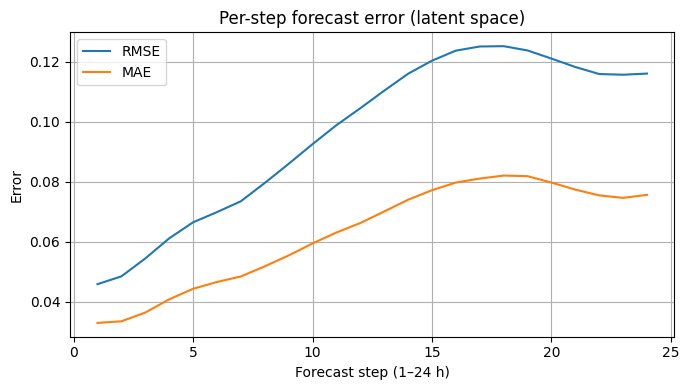

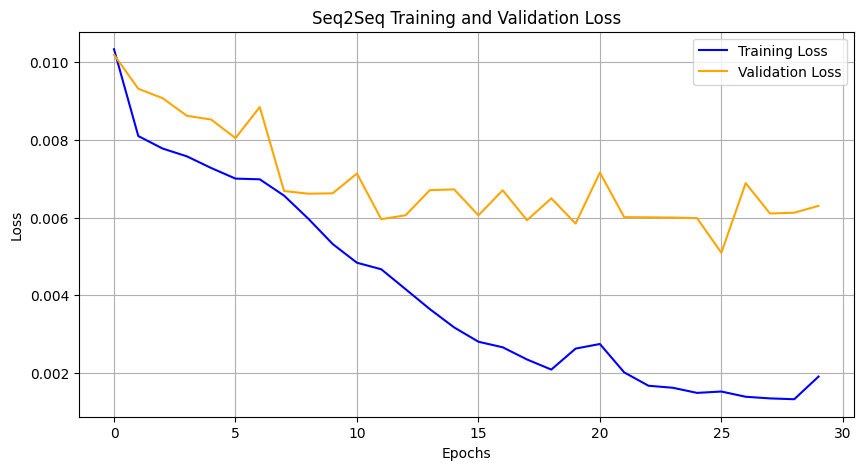

Loss curves saved to: ./output\seq2seq_loss_curves.png
Model saved to ./output\seq2seq_forecast.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Forecasted latent vectors saved to ./output\forecasted_latent_vectors.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Heatmaps saved to ./output\forecasted_heatmaps
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Final combined anomaly and forecast results saved to ./output\anomaly_forecast_results.csv


C:\Users\abraarno\AppData\Local\Temp\ipykernel_33608\3181815322.py:344: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tsne_plot_df['alarm'].fillna('Green', inplace=True)


t‑SNE plot of latent space without alarm labels saved to ./output\tsne_latent_space_no_labels.png


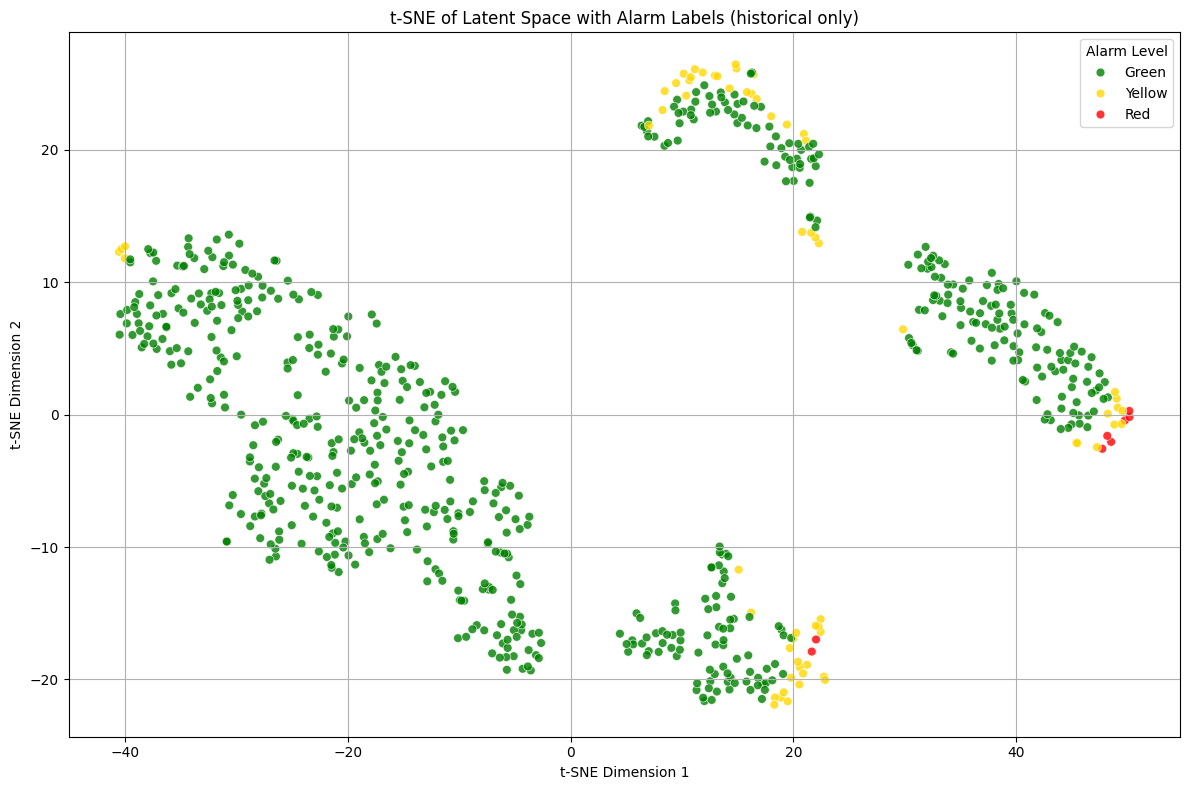

t‑SNE plot with alarm labels saved to ./output\tsne_latent_space_alarms.png
Green in combined_results: 45
Green in tsne_plot_df *after the fix*: 649
Yellow in combined_results: 3
Yellow in tsne_plot_df *after the fix*: 64
Red in combined_results: 0
Red in tsne_plot_df *after the fix*: 8
Isolation-Forest scores written to output\last24_isoforest_scores.csv
Scores exported to output\isoforest_scores_train_last24_forecast24.csv
Histogram saved to output\hist_isoforest_scores_train.png
Histogram saved to output\hist_isoforest_scores_last24.png
Histogram saved to output\hist_isoforest_scores_forecast24.png
Creating max temperature time-series visualization...
Temperature with alarms plot saved to ./output\max_temperature_alarm_plot.png


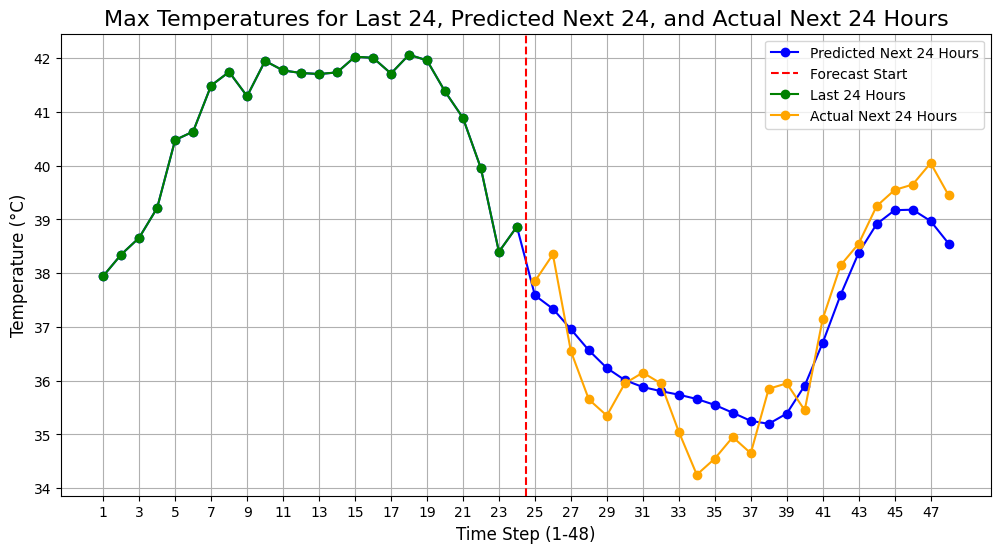

In [24]:
# --- FORECAST & VISUALISATIONS ------------------------------------------------
# • Builds a Seq2Seq LSTM on latent-vector time-series
# • Generates a 24-hour forecast, reconstructs heat-maps, and flags anomalies
# • Saves all artefacts (models, plots, CSVs) to the output folder


import os, random, glob, configparser, joblib
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam


def split_into_segments_with_gaps(df, max_small_gap_hours=3):
    """Split a time-indexed DataFrame into quasi-continuous segments."""
    df = df.sort_index()
    segments, start_idx, found_large_gap = [], 0, False
    for i in range(1, len(df)):
        dt = (df.index[i] - df.index[i-1]).total_seconds() / 3600.0
        if dt > max_small_gap_hours:
            found_large_gap = True
            seg = process_and_fill_segment(df.iloc[start_idx:i], max_small_gap_hours)
            if len(seg): segments.append(seg)
            start_idx = i
    if not found_large_gap:
        segments.append(process_and_fill_segment(df, max_small_gap_hours))
    elif start_idx < len(df):
        segments.append(process_and_fill_segment(df.iloc[start_idx:], max_small_gap_hours))
    print(f"Total segments created: {len(segments)}")
    return segments

def process_and_fill_segment(segment, max_gap_hours=3):
    """Resample hourly and linearly interpolate gaps ≤ max_gap_hours."""
    seg = segment.resample('h').asfreq()
    seg = seg.interpolate(method='linear', limit=max_gap_hours, limit_direction='forward')
    return seg.dropna(how='any')

def create_sliding_windows_from_segments(segments, input_days=7, horizon=24):
    """Create sliding (X,y) windows from every continuous segment."""
    seq_len, all_X, all_y = input_days*24, [], []
    for seg in segments:
        if len(seg) < seq_len + horizon: 
            continue
        data = seg.values
        for i in range(len(data) - seq_len - horizon + 1):
            all_X.append(data[i:i+seq_len])
            all_y.append(data[i+seq_len:i+seq_len+horizon])
    return (np.array(all_X), np.array(all_y)) if all_X else (np.empty((0,0,0)), np.empty((0,0,0)))

def apply_pattern(x_seq, pattern):
    """Blank selected days within the first 6 days of a 7-day context window."""
    x_mod = x_seq.copy()
    if pattern == 'all_6_days':
        x_mod[:144] = 0
    elif pattern == 'one_day':
        d = random.randint(0, 5); x_mod[d*24:(d+1)*24] = 0
    elif pattern == 'two_days':
        for d in random.sample(range(6), 2):
            x_mod[d*24:(d+1)*24] = 0
    return x_mod

def load_binary_data(folder):
    """Stack *.bin files (32×32×1 float32) from a folder into an array."""
    files = sorted(glob.glob(os.path.join(folder, '*.bin')))
    data = [np.fromfile(f, np.float32).reshape(32,32,1) for f in files]
    return np.stack(data), files

def run_forecast():
    np.random.seed(42)
    tf.random.set_seed(42)
    random.seed(42)

    config = configparser.ConfigParser()
    config.read('config.ini')
    output_folder = config['PATHS']['output_folder']
    input_days = int(config['FORECAST']['input_days'])
    actual_next24_binary_folder = config['PATHS']['actual_next24_binary_folder']
    latent_vectors_path = os.path.join(output_folder, "latent_vectors.csv")

    latent_vectors_df = pd.read_csv(latent_vectors_path, index_col=0,parse_dates=True)
    latent_vectors_df.sort_index(inplace=True)

    print("Latent Vectors DF:", latent_vectors_df.shape)
    print(latent_vectors_df.head())

    segments = split_into_segments_with_gaps(latent_vectors_df, max_small_gap_hours=3)
    X, y = create_sliding_windows_from_segments(
        segments,
        input_days=input_days,
        horizon=24
    )
    print("X shape after gap handling and windowing:", X.shape)
    print("y shape after gap handling and windowing:", y.shape)

    if input_days == 7:
        patterns = ['all_6_days', 'one_day', 'two_days', 'none']
        X_augmented = []
        y_augmented = []
        for i in range(X.shape[0]):
            X_seq_original = X[i]
            y_seq = y[i]
            for pat in patterns:
                X_seq_modified = apply_pattern(X_seq_original, pat)
                X_augmented.append(X_seq_modified)
                y_augmented.append(y_seq)
        X = np.array(X_augmented)
        y = np.array(y_augmented)
        print("X shape after applying blanking patterns:", X.shape)
        print("y shape after applying blanking patterns:", y.shape)

    # TIME-SERIES SPLIT (80/10/10)
    total_sequences = X.shape[0]
    train_size = int(0.8 * total_sequences)
    val_size = int(0.1 * total_sequences)
    test_size = total_sequences - train_size - val_size

    X_train = X[:train_size]
    y_train = y[:train_size]
    X_val = X[train_size:train_size + val_size]
    y_val = y[train_size:train_size + val_size]
    X_test = X[train_size + val_size:]
    y_test = y[train_size + val_size:]

    print("Train:", X_train.shape, y_train.shape)
    print("Val:", X_val.shape, y_val.shape)
    print("Test:", X_test.shape, y_test.shape)

    sequence_length = input_days * 24
    num_features = X.shape[-1]
    forecast_horizon = 24

    # Build LSTM Seq2Seq Model
    encoder_inputs = Input(shape=(sequence_length, num_features), name="encoder_inputs")
    encoder_lstm = LSTM(96, activation='tanh', return_sequences=False, name="encoder_lstm")(encoder_inputs)
    encoder_lstm = Dropout(0.2, name="encoder_dropout")(encoder_lstm)

    decoder_inputs = RepeatVector(forecast_horizon, name="decoder_repeat_vector")(encoder_lstm)
    decoder_lstm = LSTM(96, activation='tanh', return_sequences=True, name="decoder_lstm")(decoder_inputs)
    decoder_lstm = Dropout(0.2, name="decoder_dropout2")(decoder_lstm)
    decoder_outputs = TimeDistributed(Dense(num_features, activation='linear'), name="decoder_dense")(decoder_lstm)

    model = Model(encoder_inputs, decoder_outputs, name="Seq2Seq_Model")
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss="mse")
    model.summary()

    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=10, verbose=1, min_lr=1e-6)

    history = model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=8,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, lr_scheduler]
    ) 
    plot_model(model, to_file=os.path.join(output_folder, "lstmseq2seq_architecture.png"),
            show_shapes=True, show_layer_names=True)
    # Evaluate on test set
    test_loss = model.evaluate(X_test, y_test)
    print("Test Loss:", test_loss)

    # Predict on Test Set
    y_pred = model.predict(X_test)

    # Reshape for metrics calculation
    y_test_flat = y_test.reshape(-1, num_features)
    y_pred_flat = y_pred.reshape(-1, num_features)

    # Calculate Metrics
    mse = mean_squared_error(y_test_flat, y_pred_flat)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_flat, y_pred_flat)
    r2 = r2_score(y_test_flat, y_pred_flat)

    print("\nTest Set Metrics:")
    print(f"MSE : {mse:.6f}")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE : {mae:.6f}")
    print(f"R²  : {r2:.6f}")

    per_step_mae = [mean_absolute_error(y_test[:, t, :], y_pred[:, t, :])
                    for t in range(y_test.shape[1]) ]

    per_step_rmse = [np.sqrt(mean_squared_error(y_test[:, t, :], y_pred[:, t, :]))
                    for t in range(y_test.shape[1])]
    
    plt.figure(figsize=(7, 4))
    plt.plot(range(1, y_test.shape[1] + 1), per_step_rmse, label="RMSE")
    plt.plot(range(1, y_test.shape[1] + 1), per_step_mae, label="MAE")
    plt.xlabel("Forecast step (1–24 h)")
    plt.ylabel("Error")
    plt.title("Per-step forecast error (latent space)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, "per_step_latent_errors_vanilla.png"))
    plt.show()
    plt.close()

    color_map = {'Green': 'green', 'Yellow': 'gold', 'Red': 'red'}
    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.legend()
    plt.title('Seq2Seq Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plot_loss_path = os.path.join(output_folder, "seq2seq_loss_curves.png")
    plt.savefig(plot_loss_path)
    plt.show()
    print(f"Loss curves saved to: {plot_loss_path}")
    model_path = os.path.join(output_folder, "seq2seq_forecast.keras")
    model.save(model_path)
    print(f"Model saved to {model_path}")

    # FORECASTING NEXT 24 HOURS
    last_sequence = X[-1].reshape(1, sequence_length, num_features)
    forecast = model.predict(last_sequence)  
    forecast = forecast.squeeze()        

    # Reindex forecast with timestamps: let's assume the last segment ends at:
    last_timestamp = latent_vectors_df.index[-1]
    forecast_timestamps = [last_timestamp + pd.Timedelta(hours=i+1) for i in range(forecast_horizon)]

    forecasted_latent_vectors_df = pd.DataFrame(forecast, index=forecast_timestamps, 
                                                columns=latent_vectors_df.columns)
    forecasted_latent_vectors_path = os.path.join(output_folder, "forecasted_latent_vectors.csv")
    forecasted_latent_vectors_df.to_csv(forecasted_latent_vectors_path)
    print(f"Forecasted latent vectors saved to {forecasted_latent_vectors_path}")

    # --- LOAD PRE-TRAINED AUTOENCODER & RECONSTRUCT IMAGES ---
    autoencoder_path = os.path.join(output_folder, "convolutional_autoencoder.keras")
    if os.path.exists(autoencoder_path):
        from autoencoder import CustomAutoencoder
        autoencoder = load_model(autoencoder_path, custom_objects={'CustomAutoencoder': CustomAutoencoder}, compile=False)
        decoder = autoencoder.decoder()  

        image_scaler_path = os.path.join(output_folder, 'scaler.joblib')
        image_scaler = joblib.load(image_scaler_path)
        reconstructed_images = decoder.predict(forecast)  
        # Inverse scaling
        reconstructed_images_flat = reconstructed_images.reshape(-1, 1)
        reconstructed_images_original_scale = image_scaler.inverse_transform(reconstructed_images_flat)
        reconstructed_images_original_scale = reconstructed_images_original_scale.reshape(reconstructed_images.shape)

        def save_heatmaps(predicted_temperatures, output_folder):
            vmin = 10
            vmax = 40
            if not os.path.exists(output_folder):
                os.makedirs(output_folder)

            for i in range(predicted_temperatures.shape[0]):
                plt.figure(figsize=(6, 6))
                panel_data = predicted_temperatures[i, :, :, 0]
                plt.imshow(panel_data, cmap='viridis', interpolation='nearest', vmin=vmin, vmax=vmax)
                cbar = plt.colorbar(label='Temperature (°C)')
                cbar.set_ticks(np.linspace(vmin, vmax, num=11)) 
                plt.title(f'Predicted Temperature for Hour {i+1}')
                plt.savefig(os.path.join(output_folder, f'heatmap_hour_{i+1}.png'))
                plt.close()

        heatmap_dir = os.path.join(output_folder, "forecasted_heatmaps")
        save_heatmaps(reconstructed_images_original_scale, heatmap_dir)
        print(f"Heatmaps saved to {heatmap_dir}")

    # --- ISOLATION FOREST: TRAIN ONLY ON TRAIN LATENT VECTORS ---
    train_end_index = train_size + sequence_length
    latent_vectors_train_df = latent_vectors_df.iloc[:train_end_index]  

    clf_yellow = IsolationForest(random_state=42, contamination=0.1)
    clf_red = IsolationForest(random_state=42, contamination=0.01)

    clf_yellow.fit(latent_vectors_train_df.values)
    clf_red.fit(latent_vectors_train_df.values)

    def anomaly_detection(pretrained_clf_yellow, pretrained_clf_red, seq_df):
        seq_df = seq_df.copy()
        preds_yellow = pretrained_clf_yellow.predict(seq_df.values)
        preds_red = pretrained_clf_red.predict(seq_df.values)

        seq_df['alarm'] = 'Green'
        seq_df.loc[preds_yellow == -1, 'alarm'] = 'Yellow'
        seq_df.loc[preds_red == -1, 'alarm'] = 'Red'
        return seq_df

    last_24_hours_df = latent_vectors_df.tail(24)
    last_24_latent_vectors = last_24_hours_df.values

    historical_alarms = anomaly_detection(clf_yellow, clf_red, last_24_hours_df)
    forecast_alarms = anomaly_detection(clf_yellow, clf_red, forecasted_latent_vectors_df)

    reconstructed_last_24 = decoder.predict(last_24_latent_vectors)
    reconstructed_last_24_flat = reconstructed_last_24.reshape(-1, 1)
    reconstructed_last_24_original_scale = image_scaler.inverse_transform(reconstructed_last_24_flat)
    reconstructed_last_24_original_scale = reconstructed_last_24_original_scale.reshape(reconstructed_last_24.shape)

    last_24_max_temps = reconstructed_last_24_original_scale.reshape(24, 32*32).max(axis=1)
    forecast_24_max_temps = reconstructed_images_original_scale.reshape(24, 32*32).max(axis=1)

    historical_results = last_24_hours_df.copy()
    historical_results['alarm'] = historical_alarms['alarm']
    historical_results['max_temperature'] = last_24_max_temps
    historical_results['forecasted'] = 'no'

    forecast_results = forecasted_latent_vectors_df.copy()
    forecast_results['alarm'] = forecast_alarms['alarm']
    forecast_results['max_temperature'] = forecast_24_max_temps
    forecast_results['forecasted'] = 'yes'

    combined_results = pd.concat([historical_results, forecast_results])
    combined_results['datetime'] = combined_results.index.strftime('%d/%m/%Y %H:%M')
    combined_results = combined_results[['datetime', 'alarm', 'max_temperature', 'forecasted']]

    final_results_path = os.path.join(output_folder, "anomaly_forecast_results.csv")
    combined_results.to_csv(final_results_path, index=False)
    print(f"Final combined anomaly and forecast results saved to {final_results_path}")

    # PREPARE ALARM LABELS **ONLY FOR HISTORICAL ROWS**
    historical_alarms_only = (
        combined_results[combined_results['forecasted'] == 'no']
        .copy()
        .drop(columns=['datetime', 'max_temperature', 'forecasted'])
    )                         

    # COMPUTE t‑SNE ON FULL latent_vectors_df  *once*
    all_alarms_df = anomaly_detection(clf_yellow, clf_red, latent_vectors_df)

    tsne = TSNE(n_components=2,
                perplexity=30,
                init='pca',
                learning_rate='auto',
                random_state=42)

    latent_tsne = tsne.fit_transform(latent_vectors_df.values)         

    # BUILD tsne_plot_df & MERGE IN **historical** ALARMS
    tsne_plot_df = pd.DataFrame(latent_tsne,
                            columns=['TSNE1', 'TSNE2'],
                            index=latent_vectors_df.index)

    tsne_plot_df = tsne_plot_df.join(all_alarms_df['alarm'])
    tsne_plot_df['alarm'].fillna('Green', inplace=True)

    # PLOT t‑SNE WITHOUT ALARM LABELS
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=tsne_plot_df, x='TSNE1', y='TSNE2',
                    s=40, alpha=0.8, color='steelblue')

    plt.title("t‑SNE of Latent Space (historical only)")
    plt.xlabel("t‑SNE Dimension 1")
    plt.ylabel("t‑SNE Dimension 2")
    plt.grid(True)
    plt.tight_layout()

    tsne_plot_path = os.path.join(output_folder,
                                "tsne_latent_space_no_labels.png")
    plt.savefig(tsne_plot_path)
    plt.close()
    print(f"t‑SNE plot of latent space without alarm labels saved to {tsne_plot_path}")


    # PLOT t‑SNE WITH ALARM LABELS
    palette = {'Green': 'green', 'Yellow': 'gold', 'Red': 'red'}

    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=tsne_plot_df, x='TSNE1', y='TSNE2',
                    hue='alarm', palette=palette, s=40, alpha=0.8)

    plt.title("t‑SNE of Latent Space with Alarm Labels (historical only)")
    plt.xlabel("t‑SNE Dimension 1")
    plt.ylabel("t‑SNE Dimension 2")
    plt.grid(True)
    plt.legend(title="Alarm Level")
    plt.tight_layout()

    tsne_plot_path = os.path.join(output_folder,
                                "tsne_latent_space_alarms.png")
    plt.show()
    plt.savefig(tsne_plot_path)
    plt.close()
    print(f"t‑SNE plot with alarm labels saved to {tsne_plot_path}")


    for level in ['Green', 'Yellow', 'Red']:
        print(f"{level} in combined_results:",
            (combined_results['alarm'] == level).sum())

        print(f"{level} in tsne_plot_df *after the fix*:",
            (tsne_plot_df['alarm'] == level).sum())
    #  Get anomaly *scores* (not just ±1 prediction) for the last 24 h
    def anomaly_scores(clf, df):
        return -clf.score_samples(df.values)

    last_24_df   = latent_vectors_df.tail(24)
    scores_yel   = anomaly_scores(clf_yellow, last_24_df)
    scores_red   = anomaly_scores(clf_red,    last_24_df)

    scores_df = last_24_df.copy()
    scores_df['score_yellow'] = scores_yel
    scores_df['score_red']    = scores_red

    out_csv = Path(output_folder) / "last24_isoforest_scores.csv"
    scores_df.to_csv(out_csv)
    print(f"Isolation-Forest scores written to {out_csv}")

    def anomaly_scores(clf, df):
        """Return Isolation-Forest anomaly scores (larger ⇒ more anomalous)."""
        return -clf.score_samples(df.values)

    # compute scores
    scores_train      = anomaly_scores(clf_yellow, latent_vectors_train_df)
    scores_last24     = anomaly_scores(clf_yellow, last_24_hours_df)
    scores_forecast24 = anomaly_scores(clf_yellow, forecasted_latent_vectors_df)

    # common bin edges & axis limits
    all_scores = np.concatenate([scores_train, scores_last24, scores_forecast24])

    # Slight padding so the outer bars are fully visible
    xmin, xmax = all_scores.min(), all_scores.max()
    pad = 0.05 * (xmax - xmin)
    xmin -= pad
    xmax += pad

    bins = np.linspace(xmin, xmax, 25)   # 25 bins across the shared range

    # export CSV
    scores_long = pd.DataFrame({
        "timestamp": (
            list(latent_vectors_train_df.index) +
            list(last_24_hours_df.index)       +
            list(forecasted_latent_vectors_df.index)
        ),
        "window": (["train"]       * len(scores_train) +
                ["last24"]      * len(scores_last24) +
                ["forecast24"]  * len(scores_forecast24)),
        "score":  all_scores
    })

    csv_path = Path(output_folder) / "isoforest_scores_train_last24_forecast24.csv"
    scores_long.to_csv(csv_path, index=False)
    print(f"Scores exported to {csv_path}")

    # identical-scale histograms
    hist_specs = [
        ("train"      , scores_train,      "Isolation-Forest scores – training set"),
        ("last24"     , scores_last24,     "Isolation-Forest scores – last 24 h"),
        ("forecast24" , scores_forecast24, "Isolation-Forest scores – forecast 24 h"),
    ]

    for tag, arr, title in hist_specs:
        plt.figure(figsize=(6,4))
        plt.hist(arr, bins=bins, edgecolor='k')
        plt.title(title)
        plt.xlabel("−score_samples  (larger ⇒ more anomalous)")
        plt.ylabel("Count")
        plt.xlim(xmin, xmax)     
        plt.tight_layout()
        
        out_path = Path(output_folder) / f"hist_isoforest_scores_{tag}.png"
        plt.savefig(out_path)
        plt.close()
        print(f"Histogram saved to {out_path}")
    #
    # --- Max Temperature Time Series with Alarm Colors ---
    print("Creating max temperature time-series visualization...")

    combined_results['datetime'] = pd.to_datetime(combined_results.index)

    plt.figure(figsize=(14, 5))
    for alarm in ['Green', 'Yellow', 'Red']:
        if alarm in combined_results['alarm'].values:
            subset = combined_results[combined_results['alarm'] == alarm]
            plt.scatter(subset['datetime'], subset['max_temperature'], label=alarm, color=color_map[alarm], s=30)

    plt.plot(combined_results['datetime'], combined_results['max_temperature'], color='black', linewidth=1.0, alpha=0.3)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m %H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=45)
    plt.xlabel("Timestamp")
    plt.ylabel("Max Panel Temperature (°C)")
    plt.title("Max Temperatures Over Time with Anomaly Alarms")
    plt.legend()
    plt.tight_layout()

    temp_alarm_plot_path = os.path.join(output_folder, "max_temperature_alarm_plot.png")
    plt.savefig(temp_alarm_plot_path)
    plt.close()
    print(f"Temperature with alarms plot saved to {temp_alarm_plot_path}")

    # Load Actual Next 24 Hours and Compute Max Temperatures
    actual_next24_data, actual_next24_filenames = load_binary_data(actual_next24_binary_folder)
    actual_24_max_temps = actual_next24_data.reshape(24, 32*32).max(axis=1)

    # Plot Last 24 Hours, Predicted Next 24 Hours, and Actual Next 24 Hours Max Temperatures
    x_axis = np.arange(1, 49)  # 1 to 48
    max_temperatures = np.concatenate([last_24_max_temps, forecast_24_max_temps])

    plt.figure(figsize=(12, 6))
    plt.plot(x_axis, max_temperatures, marker='o', linestyle='-', label='Predicted Next 24 Hours', color='b')
    plt.axvline(x=24.5, color='r', linestyle='--', label='Forecast Start')

    # Plot the historical last 24 hours max temperatures (1-24)
    plt.plot(x_axis[:24], last_24_max_temps, marker='o', linestyle='-', label='Last 24 Hours', color='g')

    # Plot the actual next 24 hours max temperatures (25-48)
    plt.plot(x_axis[24:], actual_24_max_temps, marker='o', linestyle='-', label='Actual Next 24 Hours', color='orange')

    plt.title("Max Temperatures for Last 24, Predicted Next 24, and Actual Next 24 Hours", fontsize=16)
    plt.xlabel("Time Step (1-48)", fontsize=12)
    plt.ylabel("Temperature (°C)", fontsize=12)
    plt.xticks(ticks=np.arange(1, 49, step=2))
    plt.legend()
    plt.grid(True)

    plot_path = os.path.join(output_folder, "max_temperatures_with_actual_plot.png")
    plt.savefig(plot_path)
    plt.show()
    
run_forecast()


In [25]:
def build_attention_seq2seq_luong(sequence_length: int, forecast_horizon: int, num_features: int):
    """Return an encoder–decoder LSTM with Bahdanau/Luong‑style attention."""
    encoder_inputs = Input(shape=(sequence_length, num_features), name="encoder_inputs")

    # Encoder
    encoder_outputs, state_h, state_c = LSTM(96,activation="tanh",return_sequences=True,return_state=True,name="encoder_lstm",)(encoder_inputs)
    encoder_dropout = Dropout(0.2, name="encoder_dropout")(encoder_outputs)

    # Decoder – start from last hidden state and repeat for each forecast hour
    decoder_seed = RepeatVector(forecast_horizon, name="decoder_seed")(state_h)
    decoder_lstm_out = LSTM(96,activation="tanh",return_sequences=True,name="decoder_lstm",)(decoder_seed, initial_state=[state_h, state_c])
    decoder_dropout = Dropout(0.2, name="decoder_dropout")(decoder_lstm_out)

    # Attention over encoder outputs
    attention_layer = Attention(name="attention_layer")
    context_vector = attention_layer([decoder_dropout, encoder_dropout])  # shape: (batch, horizon, 96)

    decoder_concat = Concatenate(axis=-1, name="concat_context")([decoder_dropout,context_vector,])  # shape: (batch, horizon, 192)

    decoder_dense = TimeDistributed(
        Dense(num_features, activation="linear"), name="decoder_dense"
    )(decoder_concat)

    return Model(encoder_inputs, decoder_dense, name="Seq2Seq_Attention")

Total segments created: 1


Model: "Seq2Seq_Attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 168, 64)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 168, 96), │     61,824 │ encoder_inputs[0… │
│                     │ (None, 96),       │            │                   │
│                     │ (None, 96)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_seed        │ (None, 24, 96)    │          0 │ encoder_lstm[0][… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ (None, 24, 96)    │     74,112 │ decoder_seed[0][… │
│                     │                   │            │ encoder_lstm[0][… │
│                     │                   │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dropout     │ (None, 24, 96)    │          0 │ decoder_lstm[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_dropout     │ (None, 168, 96)   │          0 │ encoder_lstm[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 24, 96)    │          0 │ decoder_dropout[… │
│ (Attention)         │                   │            │ encoder_dropout[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_context      │ (None, 24, 192)   │          0 │ decoder_dropout[… │
│ (Concatenate)       │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 24, 64)    │     12,352 │ concat_context[0… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 148,288 (579.25 KB)

 Trainable params: 148,288 (579.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 0.0121 - val_loss: 0.0090 - learning_rate: 0.0010
Epoch 2/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0078 - val_loss: 0.0088 - learning_rate: 0.0010
Epoch 3/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0073 - val_loss: 0.0071 - learning_rate: 0.0010
Epoch 4/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0066 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 5/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0061 - val_loss: 0.0062 - learning_rate: 0.0010
Epoch 6/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0054 - val_loss: 0.0068 - learning_rate: 0.0010
Epoch 7/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0049 - val_loss: 0.0072 - learning_rate: 0.0010
Epoch 8/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0045 - val_loss: 0.0067 - learning_rate: 0.0010
Epoch 9/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0037 - val_loss: 0.0072 - learning_rate: 0.0010


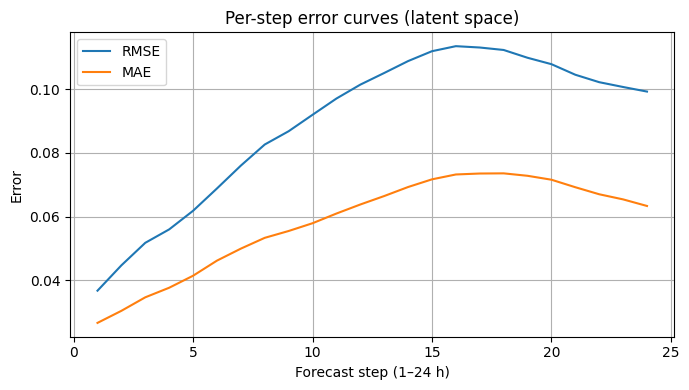

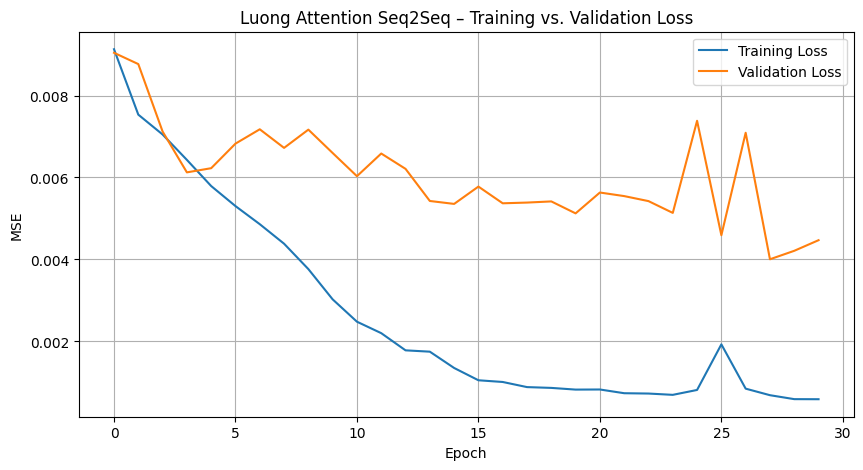

In [26]:
def attention_seq2seq_luong():
    np.random.seed(42)
    tf.random.set_seed(42)
    random.seed(42)

    latent_vectors_path = os.path.join(output_folder, "latent_vectors.csv")
    latent_vectors_df = pd.read_csv(latent_vectors_path, index_col=0, parse_dates=True)
    latent_vectors_df.sort_index(inplace=True)

    segments = split_into_segments_with_gaps(latent_vectors_df, max_small_gap_hours=3)
    X, y = create_sliding_windows_from_segments(
        segments,
        input_days=input_days,
        horizon=24,
    )
    if input_days == 7:
        patterns = ["all_6_days", "one_day", "two_days", "none"]
        X_aug, y_aug = [], []
        for i in range(len(X)):
            for pat in patterns:
                X_aug.append(apply_pattern(X[i], pat))
                y_aug.append(y[i])
        X, y = np.array(X_aug), np.array(y_aug)

    # time‑series train/val/test split (80/10/10)
    total = X.shape[0]
    train_end = int(0.8 * total)
    val_end = train_end + int(0.1 * total)

    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end:val_end], y[train_end:val_end]
    X_test, y_test = X[val_end:], y[val_end:]

    sequence_length = input_days * 24
    forecast_horizon = 24
    num_features = X.shape[-1]

    model = build_attention_seq2seq_luong(sequence_length, forecast_horizon, num_features)
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
    model.summary()

    early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
    lr_sched = ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=10, verbose=1, min_lr=1e-6)

    history = model.fit(
        X_train,
        y_train,
        epochs=30,
        batch_size=8,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, lr_sched],
    )
    plot_model(model, to_file=os.path.join(output_folder, "lstm_attention_architecture.png"),
            show_shapes=True, show_layer_names=True)

    test_loss = model.evaluate(X_test, y_test)
    print("Test Loss:", test_loss)

    # Predictions on the whole test split
    y_pred = model.predict(X_test)               
    y_true = y_test

    # Flatten   (N, horizon, features) → (N*horizon, features)
    flat_pred = y_pred.reshape(-1, num_features)
    flat_true = y_true.reshape(-1, num_features)

    mse  = mean_squared_error(flat_true, flat_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(flat_true, flat_pred)
    r2   = r2_score(flat_true, flat_pred)

    print("\n────────  Latent-space metrics on the test set  ────────")
    print(f"MSE  : {mse :.4e}")
    print(f"RMSE : {rmse:.4e}")
    print(f"MAE  : {mae :.4e}")
    print(f"R²   : {r2  :.4f}")

    # Horizon-wise curves  (optional, handy for a figure)
    per_step_mae  = [mean_absolute_error(y_true[:, t, :], y_pred[:, t, :])
                    for t in range(forecast_horizon)]
    per_step_rmse = [np.sqrt(mean_squared_error(y_true[:, t, :], y_pred[:, t, :]))
                    for t in range(forecast_horizon)]

    plt.figure(figsize=(7,4))
    plt.plot(range(1, forecast_horizon+1), per_step_rmse, label="RMSE")
    plt.plot(range(1, forecast_horizon+1), per_step_mae,  label="MAE")
    plt.xlabel("Forecast step (1–24 h)"); plt.ylabel("Error"); plt.grid(True); plt.legend()
    plt.title("Per-step error curves (latent space)")
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, "per_step_latent_errors_luong.png"))
    plt.show()
    plt.close()

    plt.figure(figsize=(10, 5))
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.legend(); plt.grid(True); plt.xlabel("Epoch"); plt.ylabel("MSE")
    plt.title("Luong Attention Seq2Seq – Training vs. Validation Loss")
    loss_plot_path = os.path.join(output_folder, "attention_seq2seq_loss_luong.png")
    plt.savefig(loss_plot_path)
    plt.show()

attention_seq2seq_luong()

In [27]:
def build_attention_seq2seq_bahdanau(sequence_length: int, forecast_horizon: int, num_features: int):
    """Return an encoder–decoder LSTM with Bahdanau/Luong‑style attention."""
    encoder_inputs = Input(shape=(sequence_length, num_features), name="encoder_inputs")

    # Encoder
    encoder_outputs, state_h, state_c = LSTM(96,activation="tanh",return_sequences=True,return_state=True,name="encoder_lstm",)(encoder_inputs)
    encoder_dropout = Dropout(0.2, name="encoder_dropout")(encoder_outputs)

    # Decoder – start from last hidden state and repeat for each forecast hour
    decoder_seed = RepeatVector(forecast_horizon, name="decoder_seed")(state_h)
    decoder_lstm_out = LSTM(96,activation="tanh",return_sequences=True,name="decoder_lstm",)(decoder_seed, initial_state=[state_h, state_c])
    decoder_dropout = Dropout(0.2, name="decoder_dropout")(decoder_lstm_out)

    # Attention over encoder outputs
    attention_layer = AdditiveAttention(name="attention_layer")
    context_vector = attention_layer([decoder_dropout, encoder_dropout])  # shape: (batch, horizon, 96)

    decoder_concat = Concatenate(axis=-1, name="concat_context")([decoder_dropout,context_vector,])  # shape: (batch, horizon, 192)

    decoder_dense = TimeDistributed(
        Dense(num_features, activation="linear"), name="decoder_dense"
    )(decoder_concat)

    return Model(encoder_inputs, decoder_dense, name="Seq2Seq_Attention")

Total segments created: 1


Model: "Seq2Seq_Attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 168, 64)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 168, 96), │     61,824 │ encoder_inputs[0… │
│                     │ (None, 96),       │            │                   │
│                     │ (None, 96)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_seed        │ (None, 24, 96)    │          0 │ encoder_lstm[0][… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ (None, 24, 96)    │     74,112 │ decoder_seed[0][… │
│                     │                   │            │ encoder_lstm[0][… │
│                     │                   │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dropout     │ (None, 24, 96)    │          0 │ decoder_lstm[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_dropout     │ (None, 168, 96)   │          0 │ encoder_lstm[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 24, 96)    │         96 │ decoder_dropout[… │
│ (AdditiveAttention) │                   │            │ encoder_dropout[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_context      │ (None, 24, 192)   │          0 │ decoder_dropout[… │
│ (Concatenate)       │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 24, 64)    │     12,352 │ concat_context[0… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 148,384 (579.62 KB)

 Trainable params: 148,384 (579.62 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0114 - val_loss: 0.0090 - learning_rate: 0.0010
Epoch 2/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0078 - val_loss: 0.0088 - learning_rate: 0.0010
Epoch 3/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0073 - val_loss: 0.0079 - learning_rate: 0.0010
Epoch 4/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0067 - val_loss: 0.0073 - learning_rate: 0.0010
Epoch 5/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0061 - val_loss: 0.0064 - learning_rate: 0.0010
Epoch 6/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0053 - val_loss: 0.0087 - learning_rate: 0.0010
Epoch 7/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0046 - val_loss: 0.0074 - learning_rate: 0.0010
Epoch 8/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0043 - val_loss: 0.0085 - learning_rate: 0.0010
Epoch 9/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0034 - val_loss: 0.0069 - learning_rate: 0.0010


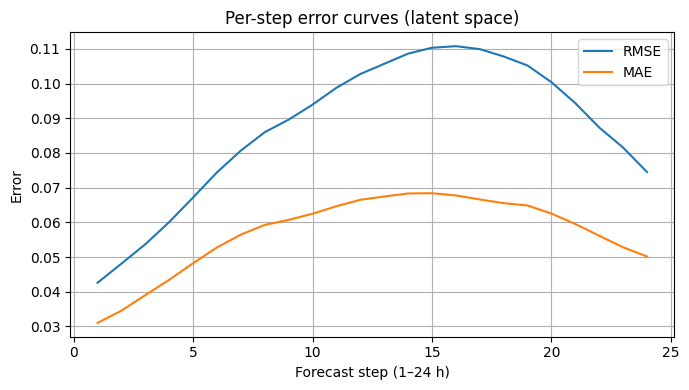

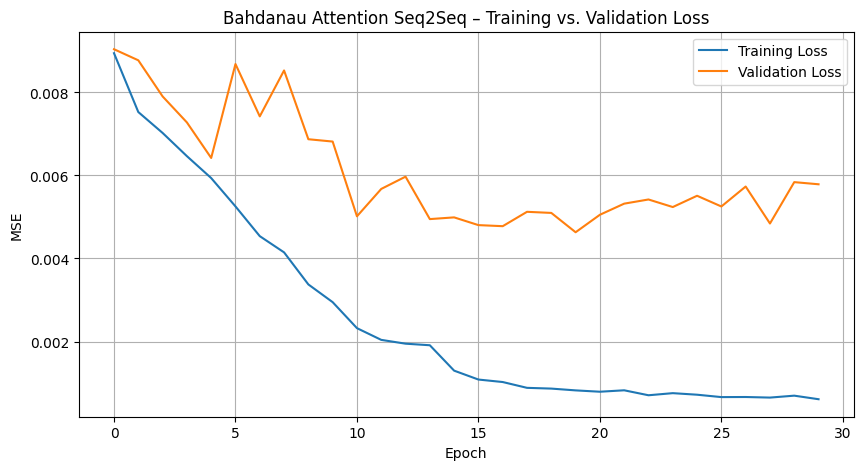

In [28]:
def attention_seq2seq_bahdanau():
    np.random.seed(42)
    tf.random.set_seed(42)
    random.seed(42)

    latent_vectors_path = os.path.join(output_folder, "latent_vectors.csv")
    latent_vectors_df = pd.read_csv(latent_vectors_path, index_col=0, parse_dates=True)
    latent_vectors_df.sort_index(inplace=True)

    # create windows exactly like baseline script
    segments = split_into_segments_with_gaps(latent_vectors_df, max_small_gap_hours=3)
    X, y = create_sliding_windows_from_segments(
        segments,
        input_days=input_days,
        horizon=24,
    )

    if input_days == 7:
        patterns = ["all_6_days", "one_day", "two_days", "none"]
        X_aug, y_aug = [], []
        for i in range(len(X)):
            for pat in patterns:
                X_aug.append(apply_pattern(X[i], pat))
                y_aug.append(y[i])
        X, y = np.array(X_aug), np.array(y_aug)

    # time‑series train/val/test split (80/10/10)
    total = X.shape[0]
    train_end = int(0.8 * total)
    val_end = train_end + int(0.1 * total)

    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end:val_end], y[train_end:val_end]
    X_test, y_test = X[val_end:], y[val_end:]

    sequence_length = input_days * 24
    forecast_horizon = 24
    num_features = X.shape[-1]

    model = build_attention_seq2seq_bahdanau(sequence_length, forecast_horizon, num_features)
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
    model.summary()

    early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
    lr_sched = ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=10, verbose=1, min_lr=1e-6)

    history = model.fit(
        X_train,
        y_train,
        epochs=30,
        batch_size=8,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, lr_sched],
    )
    plot_model(model, to_file=os.path.join(output_folder, "lstm_attention_architecture.png"),
            show_shapes=True, show_layer_names=True)
    test_loss = model.evaluate(X_test, y_test)
    print("Test Loss:", test_loss)
    y_pred = model.predict(X_test)                
    y_true = y_test
    flat_pred = y_pred.reshape(-1, num_features)
    flat_true = y_true.reshape(-1, num_features)

    mse  = mean_squared_error(flat_true, flat_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(flat_true, flat_pred)
    r2   = r2_score(flat_true, flat_pred)

    print("\n────────  Latent-space metrics on the test set  ────────")
    print(f"MSE  : {mse :.4e}")
    print(f"RMSE : {rmse:.4e}")
    print(f"MAE  : {mae :.4e}")
    print(f"R²   : {r2  :.4f}")

    # Horizon-wise curves  (optional, handy for a figure)
    per_step_mae  = [mean_absolute_error(y_true[:, t, :], y_pred[:, t, :])
                    for t in range(forecast_horizon)]
    per_step_rmse = [np.sqrt(mean_squared_error(y_true[:, t, :], y_pred[:, t, :]))
                    for t in range(forecast_horizon)]

    plt.figure(figsize=(7,4))
    plt.plot(range(1, forecast_horizon+1), per_step_rmse, label="RMSE")
    plt.plot(range(1, forecast_horizon+1), per_step_mae,  label="MAE")
    plt.xlabel("Forecast step (1–24 h)"); plt.ylabel("Error"); plt.grid(True); plt.legend()
    plt.title("Per-step error curves (latent space)")
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, "per_step_latent_errors_bahdanau.png"))
    plt.show()
    plt.close()

    plt.figure(figsize=(10, 5))
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.legend(); plt.grid(True); plt.xlabel("Epoch"); plt.ylabel("MSE")
    plt.title("Bahdanau Attention Seq2Seq – Training vs. Validation Loss")
    loss_plot_path = os.path.join(output_folder, "attention_seq2seq_loss_bahdanau.png")
    plt.savefig(loss_plot_path)
    plt.show()

attention_seq2seq_bahdanau()